In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# # Load the feature selection results
# with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
#     feature_selection = json.load(f)

# # Extract the selected features
# numerical_cols = feature_selection.get('numerical', [])
# categorical_cols = feature_selection.get('categorical', [])

# print("Numerical features:", len(numerical_cols))
# print("Categorical features:", len(categorical_cols))

In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    # numerical_cols=numerical_cols,
    # categorical_cols=categorical_cols,
    include_position_features=False,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  18


number of constant cols:  198


Numerical Columns: 588
Categorical Columns: 10


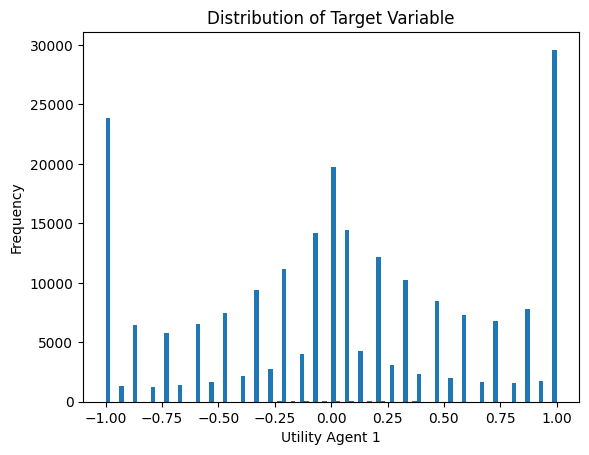

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [6]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [7]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 7,
        'learning_rate': 0.1,
        'alpha': 0.1,  # Equivalent to reg_alpha in LightGBM
        'lambda': 0.1,  # Equivalent to reg_lambda in LightGBM
        'colsample_bytree': 0.8,  # Equivalent to feature_fraction in LightGBM
        'seed': 2112,
        'verbosity': 0,  # Equivalent to verbose: -1 in LightGBM
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=2000,
            evals=[(val_data, 'val')],
            verbose_eval=25,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [8]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
# oof1.to_csv(path_results / 'oof_xgboost_cv1.csv', index=False)
# save feature importance
importance_df1.to_csv(path_results / 'feat_importance_xgboost_cv1.csv', index=False)


Fold 1


[0]	val-rmse:0.54489


[25]	val-rmse:0.48995


[50]	val-rmse:0.47705


[75]	val-rmse:0.47025


[100]	val-rmse:0.46439


[125]	val-rmse:0.46061


[150]	val-rmse:0.45805


[175]	val-rmse:0.45462


[200]	val-rmse:0.45299


[225]	val-rmse:0.45248


[250]	val-rmse:0.45112


[275]	val-rmse:0.45061


[300]	val-rmse:0.44997


[325]	val-rmse:0.44896


[350]	val-rmse:0.44877


[375]	val-rmse:0.44848


[400]	val-rmse:0.44827


[425]	val-rmse:0.44800


[450]	val-rmse:0.44798


[475]	val-rmse:0.44777


[500]	val-rmse:0.44755


[525]	val-rmse:0.44778


[550]	val-rmse:0.44737


[575]	val-rmse:0.44737


[600]	val-rmse:0.44739


[625]	val-rmse:0.44735


[650]	val-rmse:0.44753


[675]	val-rmse:0.44758


[700]	val-rmse:0.44763


[725]	val-rmse:0.44742


[750]	val-rmse:0.44749


[775]	val-rmse:0.44732


[800]	val-rmse:0.44731


[825]	val-rmse:0.44729


[850]	val-rmse:0.44739


[875]	val-rmse:0.44738


[900]	val-rmse:0.44741


[925]	val-rmse:0.44756


[950]	val-rmse:0.44766


[975]	val-rmse:0.44772


[1000]	val-rmse:0.44777


[1025]	val-rmse:0.44795


[1050]	val-rmse:0.44805


[1075]	val-rmse:0.44808


[1100]	val-rmse:0.44815


[1125]	val-rmse:0.44820


[1150]	val-rmse:0.44827


[1175]	val-rmse:0.44830


[1200]	val-rmse:0.44836


[1225]	val-rmse:0.44845


[1250]	val-rmse:0.44844


[1275]	val-rmse:0.44853


[1300]	val-rmse:0.44859


[1325]	val-rmse:0.44869


[1350]	val-rmse:0.44871


[1375]	val-rmse:0.44880


[1400]	val-rmse:0.44883


[1425]	val-rmse:0.44893


[1450]	val-rmse:0.44904


[1475]	val-rmse:0.44908


[1500]	val-rmse:0.44909


[1525]	val-rmse:0.44910


[1550]	val-rmse:0.44907


[1575]	val-rmse:0.44908


[1600]	val-rmse:0.44907


[1625]	val-rmse:0.44908


[1650]	val-rmse:0.44906


[1675]	val-rmse:0.44916


[1700]	val-rmse:0.44915


[1725]	val-rmse:0.44918


[1750]	val-rmse:0.44919


[1775]	val-rmse:0.44918


[1800]	val-rmse:0.44918


[1825]	val-rmse:0.44920


[1850]	val-rmse:0.44926


[1875]	val-rmse:0.44927


[1900]	val-rmse:0.44930


[1925]	val-rmse:0.44936


[1950]	val-rmse:0.44941


[1975]	val-rmse:0.44943


[1999]	val-rmse:0.44945


Fold 1 - RMSE: 0.4490082171005587
Fold 2


[0]	val-rmse:0.57724


[25]	val-rmse:0.49382


[50]	val-rmse:0.48359


[75]	val-rmse:0.47628


[100]	val-rmse:0.47123


[125]	val-rmse:0.46823


[150]	val-rmse:0.46494


[175]	val-rmse:0.46321


[200]	val-rmse:0.46279


[225]	val-rmse:0.46271


[250]	val-rmse:0.46135


[275]	val-rmse:0.46043


[300]	val-rmse:0.46013


[325]	val-rmse:0.45982


[350]	val-rmse:0.45945


[375]	val-rmse:0.45930


[400]	val-rmse:0.45911


[425]	val-rmse:0.45902


[450]	val-rmse:0.45869


[475]	val-rmse:0.45824


[500]	val-rmse:0.45810


[525]	val-rmse:0.45776


[550]	val-rmse:0.45764


[575]	val-rmse:0.45753


[600]	val-rmse:0.45735


[625]	val-rmse:0.45748


[650]	val-rmse:0.45725


[675]	val-rmse:0.45720


[700]	val-rmse:0.45713


[725]	val-rmse:0.45705


[750]	val-rmse:0.45713


[775]	val-rmse:0.45705


[800]	val-rmse:0.45687


[825]	val-rmse:0.45689


[850]	val-rmse:0.45696


[875]	val-rmse:0.45684


[900]	val-rmse:0.45697


[925]	val-rmse:0.45699


[950]	val-rmse:0.45699


[975]	val-rmse:0.45705


[1000]	val-rmse:0.45706


[1025]	val-rmse:0.45712


[1050]	val-rmse:0.45711


[1075]	val-rmse:0.45714


[1100]	val-rmse:0.45711


[1125]	val-rmse:0.45712


[1150]	val-rmse:0.45710


[1175]	val-rmse:0.45718


[1200]	val-rmse:0.45725


[1225]	val-rmse:0.45733


[1250]	val-rmse:0.45740


[1275]	val-rmse:0.45745


[1300]	val-rmse:0.45750


[1325]	val-rmse:0.45750


[1350]	val-rmse:0.45747


[1375]	val-rmse:0.45749


[1400]	val-rmse:0.45747


[1425]	val-rmse:0.45756


[1450]	val-rmse:0.45753


[1475]	val-rmse:0.45746


[1500]	val-rmse:0.45746


[1525]	val-rmse:0.45744


[1550]	val-rmse:0.45749


[1575]	val-rmse:0.45748


[1600]	val-rmse:0.45748


[1625]	val-rmse:0.45746


[1650]	val-rmse:0.45741


[1675]	val-rmse:0.45741


[1700]	val-rmse:0.45737


[1725]	val-rmse:0.45745


[1750]	val-rmse:0.45743


[1775]	val-rmse:0.45742


[1800]	val-rmse:0.45744


[1825]	val-rmse:0.45744


[1850]	val-rmse:0.45744


[1875]	val-rmse:0.45747


[1900]	val-rmse:0.45752


[1925]	val-rmse:0.45764


[1950]	val-rmse:0.45764


[1975]	val-rmse:0.45771


[1999]	val-rmse:0.45778


Fold 2 - RMSE: 0.4569056846229123
Fold 3


[0]	val-rmse:0.59540


[25]	val-rmse:0.50327


[50]	val-rmse:0.48759


[75]	val-rmse:0.48288


[100]	val-rmse:0.47823


[125]	val-rmse:0.47388


[150]	val-rmse:0.47135


[175]	val-rmse:0.46914


[200]	val-rmse:0.46783


[225]	val-rmse:0.46688


[250]	val-rmse:0.46524


[275]	val-rmse:0.46447


[300]	val-rmse:0.46442


[325]	val-rmse:0.46369


[350]	val-rmse:0.46310


[375]	val-rmse:0.46290


[400]	val-rmse:0.46275


[425]	val-rmse:0.46246


[450]	val-rmse:0.46211


[475]	val-rmse:0.46207


[500]	val-rmse:0.46200


[525]	val-rmse:0.46197


[550]	val-rmse:0.46173


[575]	val-rmse:0.46156


[600]	val-rmse:0.46156


[625]	val-rmse:0.46154


[650]	val-rmse:0.46147


[675]	val-rmse:0.46161


[700]	val-rmse:0.46141


[725]	val-rmse:0.46150


[750]	val-rmse:0.46171


[775]	val-rmse:0.46152


[800]	val-rmse:0.46157


[825]	val-rmse:0.46145


[850]	val-rmse:0.46142


[875]	val-rmse:0.46144


[900]	val-rmse:0.46127


[925]	val-rmse:0.46129


[950]	val-rmse:0.46138


[975]	val-rmse:0.46144


[1000]	val-rmse:0.46164


[1025]	val-rmse:0.46171


[1050]	val-rmse:0.46162


[1075]	val-rmse:0.46163


[1100]	val-rmse:0.46158


[1125]	val-rmse:0.46158


[1150]	val-rmse:0.46162


[1175]	val-rmse:0.46144


[1200]	val-rmse:0.46136


[1225]	val-rmse:0.46145


[1250]	val-rmse:0.46153


[1275]	val-rmse:0.46155


[1300]	val-rmse:0.46156


[1325]	val-rmse:0.46166


[1350]	val-rmse:0.46166


[1375]	val-rmse:0.46164


[1400]	val-rmse:0.46168


[1425]	val-rmse:0.46171


[1450]	val-rmse:0.46174


[1475]	val-rmse:0.46175


[1500]	val-rmse:0.46179


[1525]	val-rmse:0.46185


[1550]	val-rmse:0.46189


[1575]	val-rmse:0.46188


[1600]	val-rmse:0.46193


[1625]	val-rmse:0.46196


[1650]	val-rmse:0.46196


[1675]	val-rmse:0.46201


[1700]	val-rmse:0.46203


[1725]	val-rmse:0.46206


[1750]	val-rmse:0.46212


[1775]	val-rmse:0.46219


[1800]	val-rmse:0.46223


[1825]	val-rmse:0.46225


[1850]	val-rmse:0.46230


[1875]	val-rmse:0.46228


[1900]	val-rmse:0.46236


[1925]	val-rmse:0.46233


[1950]	val-rmse:0.46233


[1975]	val-rmse:0.46232


[1999]	val-rmse:0.46235


Fold 3 - RMSE: 0.46149360161840786
Fold 4


[0]	val-rmse:0.58708


[25]	val-rmse:0.50096


[50]	val-rmse:0.48535


[75]	val-rmse:0.47840


[100]	val-rmse:0.47440


[125]	val-rmse:0.47052


[150]	val-rmse:0.46800


[175]	val-rmse:0.46643


[200]	val-rmse:0.46515


[225]	val-rmse:0.46416


[250]	val-rmse:0.46299


[275]	val-rmse:0.46240


[300]	val-rmse:0.46167


[325]	val-rmse:0.46058


[350]	val-rmse:0.46021


[375]	val-rmse:0.46003


[400]	val-rmse:0.45968


[425]	val-rmse:0.45968


[450]	val-rmse:0.45922


[475]	val-rmse:0.45876


[500]	val-rmse:0.45855


[525]	val-rmse:0.45839


[550]	val-rmse:0.45845


[575]	val-rmse:0.45843


[600]	val-rmse:0.45827


[625]	val-rmse:0.45841


[650]	val-rmse:0.45842


[675]	val-rmse:0.45826


[700]	val-rmse:0.45814


[725]	val-rmse:0.45819


[750]	val-rmse:0.45824


[775]	val-rmse:0.45825


[800]	val-rmse:0.45839


[825]	val-rmse:0.45849


[850]	val-rmse:0.45846


[875]	val-rmse:0.45858


[900]	val-rmse:0.45859


[925]	val-rmse:0.45854


[950]	val-rmse:0.45854


[975]	val-rmse:0.45863


[1000]	val-rmse:0.45866


[1025]	val-rmse:0.45873


[1050]	val-rmse:0.45863


[1075]	val-rmse:0.45868


[1100]	val-rmse:0.45866


[1125]	val-rmse:0.45858


[1150]	val-rmse:0.45865


[1175]	val-rmse:0.45862


[1200]	val-rmse:0.45863


[1225]	val-rmse:0.45859


[1250]	val-rmse:0.45867


[1275]	val-rmse:0.45881


[1300]	val-rmse:0.45885


[1325]	val-rmse:0.45889


[1350]	val-rmse:0.45901


[1375]	val-rmse:0.45899


[1400]	val-rmse:0.45910


[1425]	val-rmse:0.45910


[1450]	val-rmse:0.45916


[1475]	val-rmse:0.45913


[1500]	val-rmse:0.45922


[1525]	val-rmse:0.45926


[1550]	val-rmse:0.45933


[1575]	val-rmse:0.45936


[1600]	val-rmse:0.45935


[1625]	val-rmse:0.45945


[1650]	val-rmse:0.45956


[1675]	val-rmse:0.45961


[1700]	val-rmse:0.45958


[1725]	val-rmse:0.45958


[1750]	val-rmse:0.45960


[1775]	val-rmse:0.45954


[1800]	val-rmse:0.45958


[1825]	val-rmse:0.45962


[1850]	val-rmse:0.45963


[1875]	val-rmse:0.45961


[1900]	val-rmse:0.45963


[1925]	val-rmse:0.45966


[1950]	val-rmse:0.45970


[1975]	val-rmse:0.45975


[1999]	val-rmse:0.45978


Fold 4 - RMSE: 0.4588983610345478
Fold 5


[0]	val-rmse:0.54084


[25]	val-rmse:0.46899


[50]	val-rmse:0.44826


[75]	val-rmse:0.44237


[100]	val-rmse:0.43663


[125]	val-rmse:0.43254


[150]	val-rmse:0.42788


[175]	val-rmse:0.42359


[200]	val-rmse:0.42176


[225]	val-rmse:0.41876


[250]	val-rmse:0.41735


[275]	val-rmse:0.41631


[300]	val-rmse:0.41526


[325]	val-rmse:0.41432


[350]	val-rmse:0.41391


[375]	val-rmse:0.41378


[400]	val-rmse:0.41365


[425]	val-rmse:0.41349


[450]	val-rmse:0.41326


[475]	val-rmse:0.41298


[500]	val-rmse:0.41310


[525]	val-rmse:0.41293


[550]	val-rmse:0.41281


[575]	val-rmse:0.41281


[600]	val-rmse:0.41276


[625]	val-rmse:0.41280


[650]	val-rmse:0.41293


[675]	val-rmse:0.41291


[700]	val-rmse:0.41293


[725]	val-rmse:0.41291


[750]	val-rmse:0.41297


[775]	val-rmse:0.41286


[800]	val-rmse:0.41289


[825]	val-rmse:0.41299


[850]	val-rmse:0.41313


[875]	val-rmse:0.41316


[900]	val-rmse:0.41311


[925]	val-rmse:0.41312


[950]	val-rmse:0.41305


[975]	val-rmse:0.41294


[1000]	val-rmse:0.41300


[1025]	val-rmse:0.41310


[1050]	val-rmse:0.41328


[1075]	val-rmse:0.41338


[1100]	val-rmse:0.41341


[1125]	val-rmse:0.41336


[1150]	val-rmse:0.41343


[1175]	val-rmse:0.41340


[1200]	val-rmse:0.41345


[1225]	val-rmse:0.41353


[1250]	val-rmse:0.41360


[1275]	val-rmse:0.41365


[1300]	val-rmse:0.41364


[1325]	val-rmse:0.41371


[1350]	val-rmse:0.41377


[1375]	val-rmse:0.41386


[1400]	val-rmse:0.41387


[1425]	val-rmse:0.41391


[1450]	val-rmse:0.41401


[1475]	val-rmse:0.41398


[1500]	val-rmse:0.41394


[1525]	val-rmse:0.41396


[1550]	val-rmse:0.41406


[1575]	val-rmse:0.41410


[1600]	val-rmse:0.41419


[1625]	val-rmse:0.41424


[1650]	val-rmse:0.41424


[1675]	val-rmse:0.41429


[1700]	val-rmse:0.41426


[1725]	val-rmse:0.41429


[1750]	val-rmse:0.41434


[1775]	val-rmse:0.41432


[1800]	val-rmse:0.41435


[1825]	val-rmse:0.41439


[1850]	val-rmse:0.41441


[1875]	val-rmse:0.41443


[1900]	val-rmse:0.41444


[1925]	val-rmse:0.41445


[1950]	val-rmse:0.41446


[1975]	val-rmse:0.41447


[1999]	val-rmse:0.41448


Fold 5 - RMSE: 0.4138218229596724
List of oof scores: [0.4490082171005587, 0.4569056846229123, 0.46149360161840786, 0.4588983610345478, 0.4138218229596724]
Average oof score: 0.44802553746721985


In [9]:
# # call the function
# trained_models2, oof2, oof_scores2 = train_models(
#     df_train,
#     'utility_agent1',
#     numerical_cols,
#     categorical_cols,
#     num_folds=5,
#     cv_random_state=19,
# )
# # save oof predictions
# oof2.to_csv(path_results / 'oof_xgboost_cv2.csv', index=False)

In [10]:
# # call the function
# trained_models3, oof3, oof_scores3 = train_models(
#     df_train,
#     'utility_agent1',
#     numerical_cols,
#     categorical_cols,
#     num_folds=5,
#     cv_random_state=23,
# )
# # save oof predictions
# oof3.to_csv(path_results / 'oof_xgboost_cv3.csv', index=False)

In [11]:
# trained_models = [*trained_models1, *trained_models2, *trained_models3]
trained_models = trained_models1

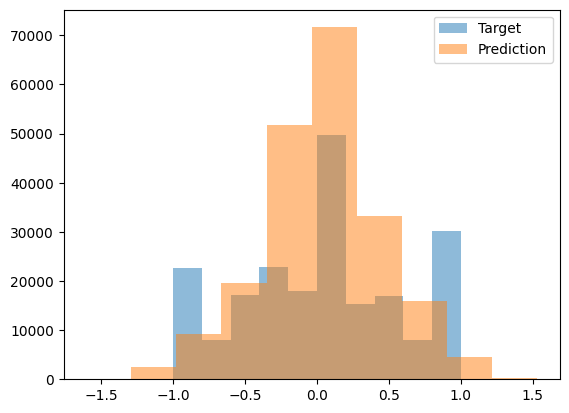

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

***